Creating a contrastive pre-training model using two embedding models using FashionMNIST. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import graphviz
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import norm

cmap = "gray"

In [2]:
train_data = torchvision.datasets.FashionMNIST(
    "./data/", download=True, transform=transforms.Compose([transforms.ToTensor()])
)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 2.88MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 40.2MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 23.0MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



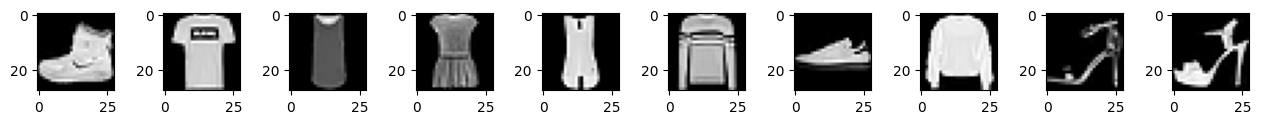

In [3]:
def show_images(dataset, num_samples=10):
    plt.figure(figsize=(16, 1))
    for i, img in enumerate(dataset):
        if i == num_samples:
            return
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(torch.squeeze(img[0]), cmap=cmap)

show_images(train_data)

In [4]:
Gx = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], dtype=torch.float)
Gy = torch.tensor([[[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]]], dtype=torch.float)
print("Gx:")
print(Gx)
print("Gy:")
print(Gy)

Gx:
tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])
Gy:
tensor([[[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]]])


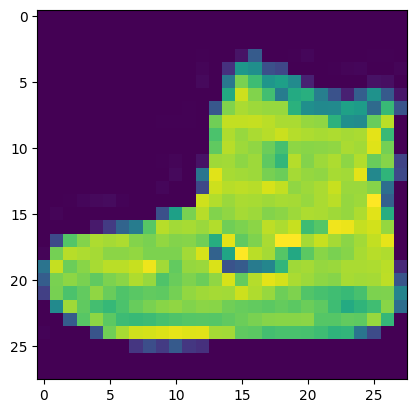

In [5]:
img = train_data[0][0][0]
plt.imshow(img)

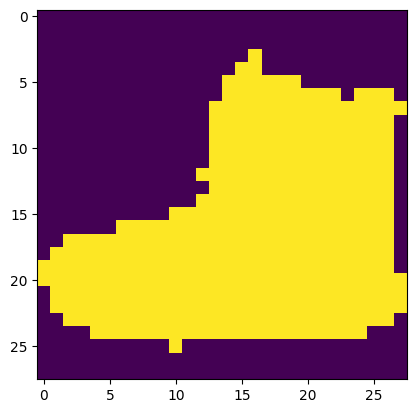

In [6]:
threshold = 0.25
new_img = img.clone()
new_img[new_img > threshold] = 1
new_img[new_img <= threshold] = 0
plt.imshow(new_img)

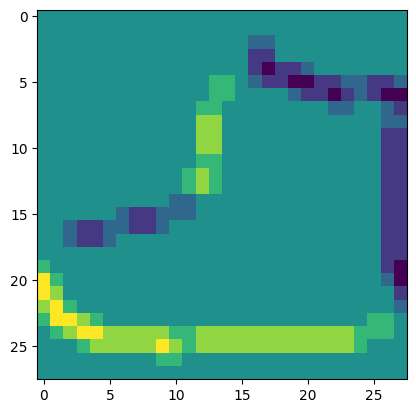

In [7]:
edges_x = F.conv2d(new_img[None, :,:], Gx, stride=1, padding=1)
edges_y = F.conv2d(new_img[None, :,:], Gy, stride=1, padding=1)
edges = edges_x + edges_y
edges = edges[0] 
plt.imshow(edges)

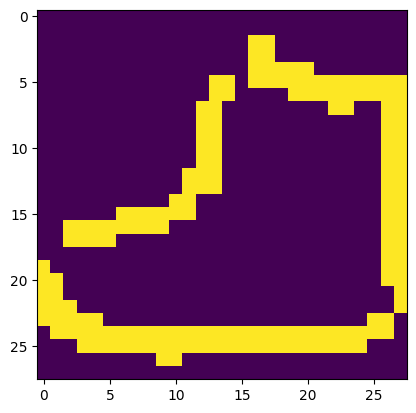

In [8]:
outline = edges
outline[edges != 0] = 1
plt.imshow(outline)

In [12]:
def outline_img(img):
    threshold = 0.25
    new_img = img.clone()
    new_img[new_img > threshold] = 1
    new_img[new_img <= threshold] = 0
    edges_x = F.conv2d(new_img, Gx, stride=1, padding=1)
    edges_y = F.conv2d(new_img, Gy, stride=1, padding=1)
    edges = edges_x + edges_y
    edges[edges != 0] = 1
    return edges
    

In [10]:
def outline_img(img):
    threshold = 0.25
    new_img = img.clone()
    new_img[new_img > threshold] = 1
    new_img[new_img <= threshold] = 0
    edges_x = F.conv2d(new_img, Gx, stride=1, padding=1)
    edges_y = F.conv2d(new_img, Gy, stride=1, padding=1)
    edges = edges_x + edges_y
    edges[edges != 0] = 1
    return edges

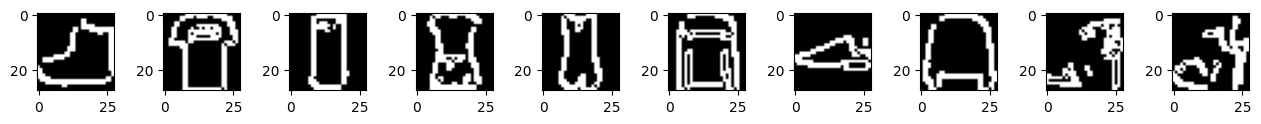

In [13]:
def show_outlined_images(dataset, num_samples=10):
    plt.figure(figsize=(16, 1))
    for i, img in enumerate(dataset):
        if i == num_samples:
            return
        plt.subplot(1, num_samples, i + 1)
        img = img[0][None, :, :, :]
        img = torch.squeeze(outline_img(img))
        plt.imshow(img, cmap=cmap)

show_outlined_images(train_data)

In [14]:
IMG_SIZE = 28
BATCH_SIZE = 6

def load_fashionMNIST(data_transform, train=True):
    return torchvision.datasets.FashionMNIST(
        "./",
        download=True,
        train=train,
        transform=data_transform,
    )


def load_transformed_fashionMNIST():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.RandomHorizontalFlip()
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)
    return train_set, test_set

train_set, valid_set = load_transformed_fashionMNIST()
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 2.34MB/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 40.0MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.7MB/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



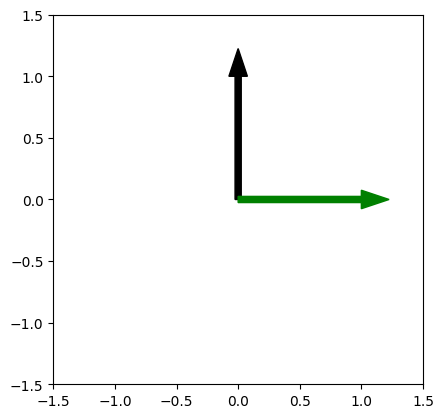

Cosine Similarity: 0.0


In [15]:
x1, y1 = [0, 1] # Change me
x2, y2 = [1, 0] # Change me

p1 = [x1, y1]
p2 = [x2, y2]

arrow_width = 0.05
plt.axis('square')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.arrow(0, 0, x1, y1, width=arrow_width, color="black")
plt.arrow(0, 0, x2, y2, width=arrow_width, color="green")
plt.show()

cosine = np.dot(p1, p2) / (norm(p1) * norm(p2))
print("Cosine Similarity:", cosine)

In [16]:
p1 = [1, 8, 6, 7]
p2 = [5, 3, 0, 9]

cosine = np.dot(p1, p2) / (norm(p1) * norm(p2))
print("Cosine Similarity:", cosine)

Cosine Similarity: 0.7004760286167305


In [17]:
class ImgEmbedder(nn.Module):
    def __init__(
        self, in_ch, img_size, down_ch_1=32, down_ch_2=64, embed_dim=10
    ):
        super().__init__()
        kernel_size = 3
        stride = 1
        padding = 1

        # Convolution
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, down_ch_1, kernel_size, stride, padding),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(down_ch_1, down_ch_2, kernel_size, stride, padding),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Flatten(),
            nn.Linear(down_ch_2 * (img_size // 4) ** 2, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim),
        )

    def forward(self, x):
        conv = self.conv(x)
        emb = self.dense_emb(conv)
        return F.normalize(emb)

In [18]:
x = torch.tensor([1, 2, 3])
repeat_x = x.repeat(3)
repeat_interleave = x.repeat_interleave(3)
print("repeat: ", repeat_x)
print("repeat_interleave: ", repeat_interleave)

repeat:  tensor([1, 2, 3, 1, 2, 3, 1, 2, 3])
repeat_interleave:  tensor([1, 1, 1, 2, 2, 2, 3, 3, 3])


In [19]:
print(torch.unflatten(repeat_x, 0, (3, 3)))

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])


In [20]:
print(torch.unflatten(repeat_interleave, 0, (3, 3)))

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])


In [21]:
class ContrastivePretraining(nn.Module):
    def __init__(self, in_ch, img_size, embed_dim=10):
        super().__init__()
        self.baseImgEmbedder = ImgEmbedder(in_ch, img_size, down_ch_2=128, embed_dim=embed_dim)
        self.outlineEmbedder = ImgEmbedder(in_ch, img_size, embed_dim=embed_dim)
        self.cos = nn.CosineSimilarity()

    def forward(self, base_imgs, outlined_imgs):
        base_emb = self.baseImgEmbedder(base_imgs)
        outline_emb = self.outlineEmbedder(outlined_imgs)

        repeated_base_emb = base_emb.repeat_interleave(len(outline_emb), dim=0)
        repeated_outline_emb = outline_emb.repeat(len(base_emb), 1)

        similarity = self.cos(repeated_base_emb, repeated_outline_emb)
        similarity = torch.unflatten(similarity, 0, (BATCH_SIZE, BATCH_SIZE))
        similarity = (similarity + 1) / 2

        logits_per_base = similarity
        logits_per_outline = similarity.T
        return logits_per_base, logits_per_outline

In [22]:
model = ContrastivePretraining(1, 28)
optimizer = Adam(model.parameters(), lr=0.0001)
loss_base = nn.CrossEntropyLoss()
loss_outline = nn.CrossEntropyLoss()
ground_truth = torch.arange(BATCH_SIZE, dtype=torch.long)
epochs = 1

In [23]:
for epoch in range(epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        images = batch[0]
        outlines = outline_img(images)
        logits_per_base, logits_per_outline = model(images, outlines)
        total_loss = (loss_base(logits_per_base, ground_truth) + loss_outline(logits_per_outline, ground_truth))/2
        total_loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 2000 == 0:
            print(f"Train Epoch {epoch} | Step {step:03d} Loss: {total_loss.item()} ")
            print("Similarity:")
            print(logits_per_base)
    model.eval()
    valid_loss = 0
    for step, batch in enumerate(valid_dataloader):
        images = batch[0]
        outlines = outline_img(images)
        logits_per_base, logits_per_outline = model(images, outlines)
        total_loss = (loss_base(logits_per_base, ground_truth) + loss_outline(logits_per_outline, ground_truth))/2
        total_loss.backward()
        optimizer.step()
        valid_loss += total_loss.item()

    print(f"Valid Loss: {valid_loss / step} ")
    print("Similarity:")
    print(logits_per_base)

Train Epoch 0 | Step 000 Loss: 1.791694164276123 
Similarity:
tensor([[0.4656, 0.4866, 0.4732, 0.5025, 0.4829, 0.4737],
        [0.4650, 0.4850, 0.4725, 0.5021, 0.4823, 0.4720],
        [0.4702, 0.4895, 0.4777, 0.5077, 0.4877, 0.4760],
        [0.4645, 0.4825, 0.4709, 0.5018, 0.4819, 0.4688],
        [0.4579, 0.4768, 0.4647, 0.4957, 0.4755, 0.4630],
        [0.4709, 0.4896, 0.4778, 0.5079, 0.4883, 0.4762]],
       grad_fn=<DivBackward0>)
Train Epoch 0 | Step 2000 Loss: 1.549461841583252 
Similarity:
tensor([[0.9877, 0.6658, 0.7806, 0.9869, 0.9955, 0.1470],
        [0.7230, 0.9891, 0.9734, 0.5484, 0.6356, 0.7134],
        [0.7307, 0.9895, 0.9759, 0.5570, 0.6438, 0.7059],
        [0.9877, 0.6658, 0.7806, 0.9869, 0.9955, 0.1470],
        [0.9877, 0.6658, 0.7806, 0.9869, 0.9955, 0.1470],
        [0.2146, 0.7086, 0.5803, 0.0976, 0.1481, 0.9928]],
       grad_fn=<DivBackward0>)
Train Epoch 0 | Step 4000 Loss: 1.4676246643066406 
Similarity:
tensor([[0.9991, 0.5577, 0.9296, 0.0286, 0.9501, 0.

In [24]:
gray_mode = torchvision.io.ImageReadMode.GRAY
my_outline = torchvision.io.read_image("images/my_outline.png", gray_mode)
my_outline = my_outline.float() / 255
my_outline.size()

torch.Size([1, 28, 28])

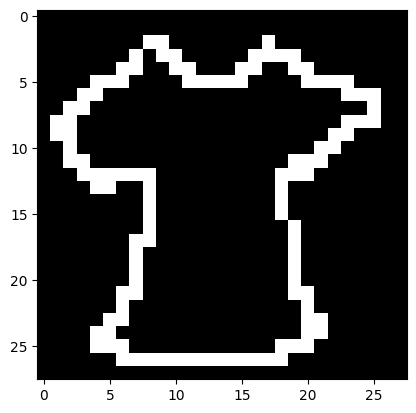

In [25]:
plt.imshow(my_outline[0], cmap=cmap)

In [26]:
my_batched_outline = my_outline[None,:,:,:]
my_batched_outline.size()

torch.Size([1, 1, 28, 28])

In [27]:
out_emb = model.outlineEmbedder(my_batched_outline)
out_emb

tensor([[-0.5179, -0.3540, -0.0263, -0.0921, -0.1182, -0.1876,  0.0829,  0.5374,
          0.1021,  0.4919]], grad_fn=<DivBackward0>)

In [28]:
best_score = -1
best_img = None
compare_batch_size = 5000

cos = nn.CosineSimilarity()
repeated_out_emb = out_emb.repeat(len(out_emb), 1)
compare_dataloader = DataLoader(train_set, batch_size=compare_batch_size)

In [29]:
for step, batch in enumerate(compare_dataloader):
    images = batch[0]
    img_embs = model.baseImgEmbedder(images)
    scores = cos(img_embs, repeated_out_emb)
    best_idx = torch.argmax(scores)
    batch_best_score = scores[best_idx]
    print("Step:", step, "| Batch Best Score:", batch_best_score.item())
    if batch_best_score.item() > best_score:
        best_score = batch_best_score.item()
        best_img = images[best_idx]
print("Best Score: ", best_score)

Step: 0 | Batch Best Score: 0.9961545467376709
Step: 1 | Batch Best Score: 0.9961808323860168
Step: 2 | Batch Best Score: 0.9960684180259705
Step: 3 | Batch Best Score: 0.9961466789245605
Step: 4 | Batch Best Score: 0.9961631298065186
Step: 5 | Batch Best Score: 0.9961087703704834
Step: 6 | Batch Best Score: 0.99617999792099
Step: 7 | Batch Best Score: 0.996168851852417
Step: 8 | Batch Best Score: 0.9961473345756531
Step: 9 | Batch Best Score: 0.9961389899253845
Step: 10 | Batch Best Score: 0.9961925148963928
Step: 11 | Batch Best Score: 0.9961713552474976
Best Score:  0.9961925148963928


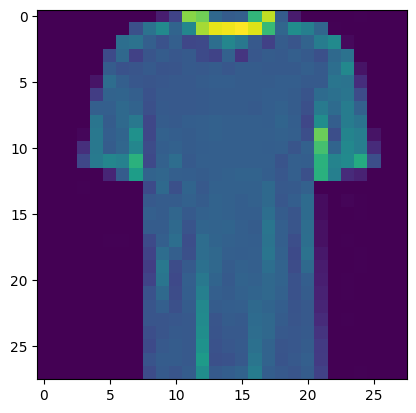

In [30]:
plt.imshow(best_img[0])

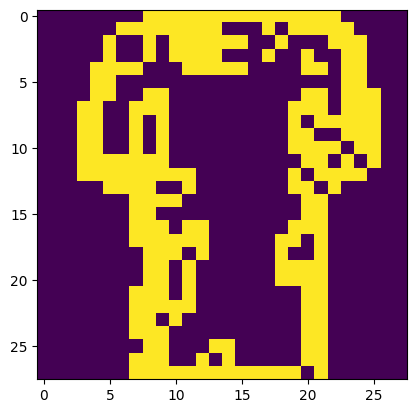

In [31]:
compare_outline = outline_img(best_img)
plt.imshow(compare_outline[0])

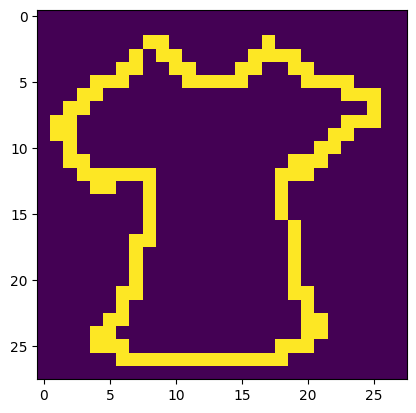

In [32]:
plt.imshow(my_outline[0])